# Melanoma Detection Assignment

### Importing necessary libraries

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import glob

### Mounting the google drive for importing data:

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Defining the path for train and test images

In [4]:
data_dir_train = pathlib.Path("/content/gdrive/My Drive/data/Train")
data_dir_test = pathlib.Path('/content/gdrive/My Drive/data/Test')

### Checking the image count for both train and test images

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2257
118


### Defining a method to load the data and splitting into training & validation set

In [7]:
def split_train_validation_data(data_dir,img_height,img_width,seed,batch_size,validation_split):
    train_data = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        seed=seed,
        validation_split= validation_split,
        subset= 'training',
        image_size=(img_height,img_width),
        label_mode = 'categorical',
        batch_size = batch_size
    )
    validation_data = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        seed=seed,
        validation_split= validation_split,
        subset= 'validation',
        image_size=(img_height,img_width),
        label_mode = 'categorical',
        batch_size = batch_size
    )
    return train_data, validation_data

## Creating the dataset

In [6]:
batch_size = 32
img_height = 180
img_width = 180

##### Using 80-20 ratio for training and validation set

In [8]:
train_ds, val_ds = split_train_validation_data(data_dir_train,img_height,img_width,123,batch_size,0.2)

Found 2257 files belonging to 9 classes.
Using 1806 files for training.
Found 2257 files belonging to 9 classes.
Using 451 files for validation.


### Checking the class names of the image data

In [9]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualizing the data

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def plot_images_from_class(data_dir,class_names):
  plt.figure(figsize=(10,10))
  for i in range(len(class_names)):
    plt.subplot(3, 3, i + 1)
    image = mpimg.imread(str(list(data_dir.glob(class_names[i]+'/*.jpg'))[1]))
    plt.title(class_names[i])
    plt.imshow(image)

### Plotting one image from each class

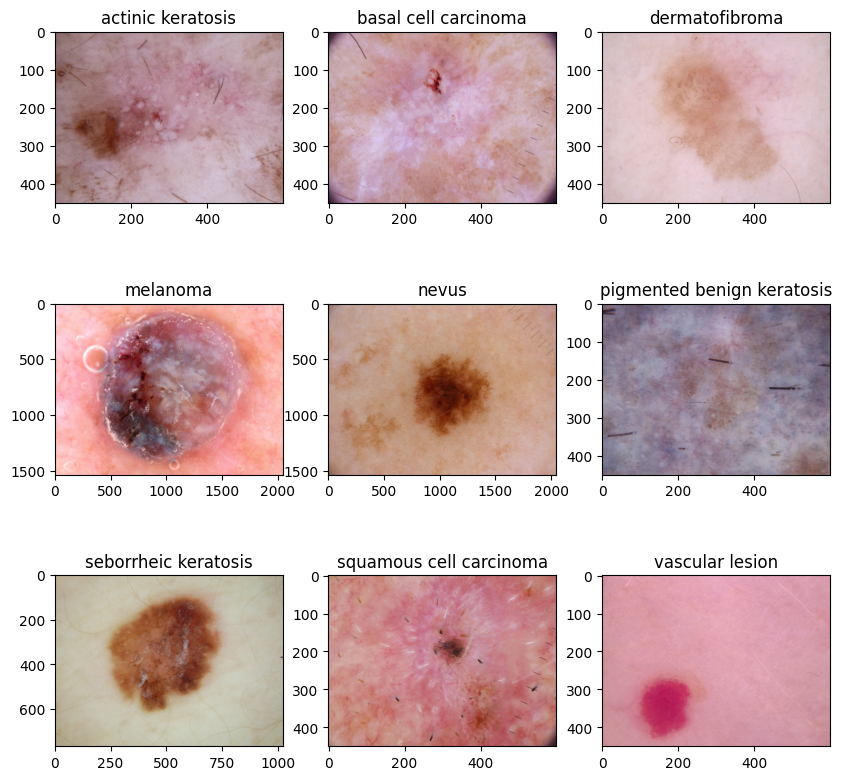

In [11]:
plot_images_from_class(data_dir_train,class_names)

##### Using cache() & prefetch() on the training & validation dataset for faster processing

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Defining a method to add layers on the model

In [13]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
def add_layers_to_model(model, num_classes):
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(img_height, img_width,3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    return model

## Creating the first model and compiling

##### Here the loss function is chosen as 'categorical_crossentropy' and optimizer as 'sgd'

In [14]:
model = Sequential([layers.Rescaling(1./255, input_shape=(img_height, img_width,3))])
model = add_layers_to_model(model, len(class_names))
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Checking the model summary of all layers

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 178, 178, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 89, 89, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 89, 89, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 87, 87, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      60,588,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 60,659,497 (231.40 MB)

 Trainable params: 60,659,113 (231.40 MB)

 Non-trainable params: 384 (1.50 KB)

### Training the model with 20 epochs

In [16]:
epochs = 20
history1 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.2260 - loss: 19.9444 - val_accuracy: 0.1685 - val_loss: 3.9749
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.4262 - loss: 1.7953 - val_accuracy: 0.0865 - val_loss: 4.4913
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.4381 - loss: 1.5658 - val_accuracy: 0.1951 - val_loss: 5.1413
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.5225 - loss: 1.3947 - val_accuracy: 0.2373 - val_loss: 4.2331
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.5877 - loss: 1.2073 - val_accuracy: 0.3348 - val_loss: 3.7638
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.5950 - loss: 1.1393 - val_accuracy: 0.3548 - val_loss: 2.3451
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.6325 - loss: 1.0094 - val_accuracy: 0.4390 - val_loss: 2.6051
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.6698 - loss: 0.9176 - val_accuracy: 0.4812 - 

### Defining methods to visualizing and printing the model results

In [17]:
def plot_accuracy_loss(result):
    acc = result.history['accuracy']
    val_acc = result.history['val_accuracy']

    loss = result.history['loss']
    val_loss = result.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [18]:
from tabulate import tabulate
def print_accuracy_table(result):
    acc = result.history['accuracy']
    val_acc = result.history['val_accuracy']
    accuracy = list(zip(acc, val_acc))
    print(tabulate(accuracy,headers=["train_acc","test_acc"]))

### Visualizing the result of the model

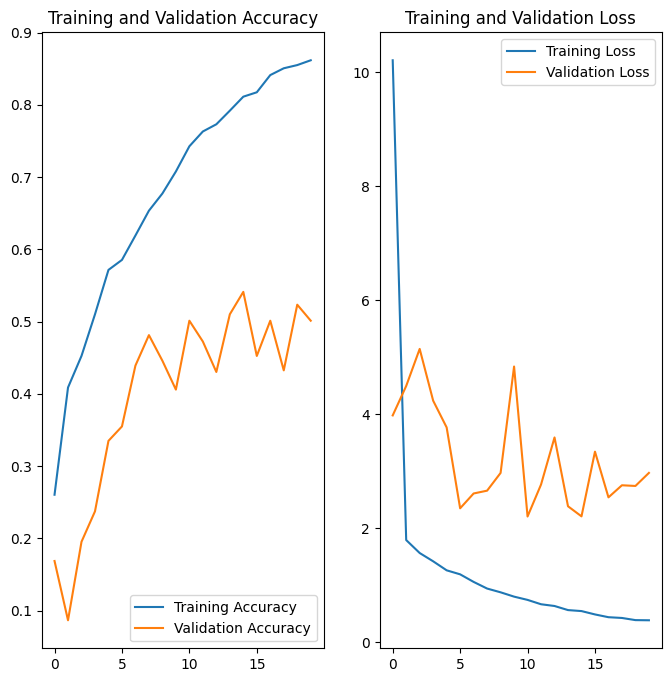

In [19]:
plot_accuracy_loss(history1)

In [20]:
print_accuracy_table(history1)

  train_acc    test_acc
-----------  ----------
   0.260244   0.168514
   0.408638   0.0864745
   0.452381   0.195122
   0.509967   0.237251
   0.571429   0.334812
   0.585271   0.354767
   0.619048   0.439024
   0.653378   0.481153
   0.677187   0.445676
   0.707641   0.405765
   0.742525   0.501109
   0.763012   0.472284
   0.772979   0.430155
   0.791805   0.509978
   0.811185   0.54102
   0.817276   0.452328
   0.841085   0.501109
   0.850498   0.432373
   0.854928   0.523282
   0.861573   0.501109


#### Here we can see that even though the training accuracy is high, the validation accuracy is very low. This indicates that the model might have overfitted. So, we need to enhance the model

## Creating second model

#### Preparing the data augmentation to be applied on training dataset

In [21]:
data_aug = keras.Sequential([
                             layers.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.RandomRotation(0.2, fill_mode='reflect'),
                             layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')])

### Creating the model

In [26]:
num_classes = 9
model2 = Sequential([ layers.Rescaling(1./255, input_shape=(img_height, img_width,3)), data_aug])
model2 = add_layers_to_model(model2,len(class_names))

### Compiling the model

In [27]:
model2.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [28]:
epochs=20
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 204ms/step - accuracy: 0.2059 - loss: 12.3053 - val_accuracy: 0.1552 - val_loss: 8.3837
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - accuracy: 0.3558 - loss: 1.8117 - val_accuracy: 0.1552 - val_loss: 13.0149
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.4086 - loss: 1.6923 - val_accuracy: 0.1574 - val_loss: 10.9672
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - accuracy: 0.4584 - loss: 1.5509 - val_accuracy: 0.2506 - val_loss: 7.9807
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.4713 - loss: 1.5069 - val_accuracy: 0.2239 - val_loss: 10.3054
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - accuracy: 0.4522 - loss: 1.5585 - val_accuracy: 0.2661 - val_loss: 6.1924
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.4931 - loss: 1.4811 - val_accuracy: 0.3570 - val_loss: 6.3470
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.4750 - loss: 1.4926 - val_a

### Visualizing the results

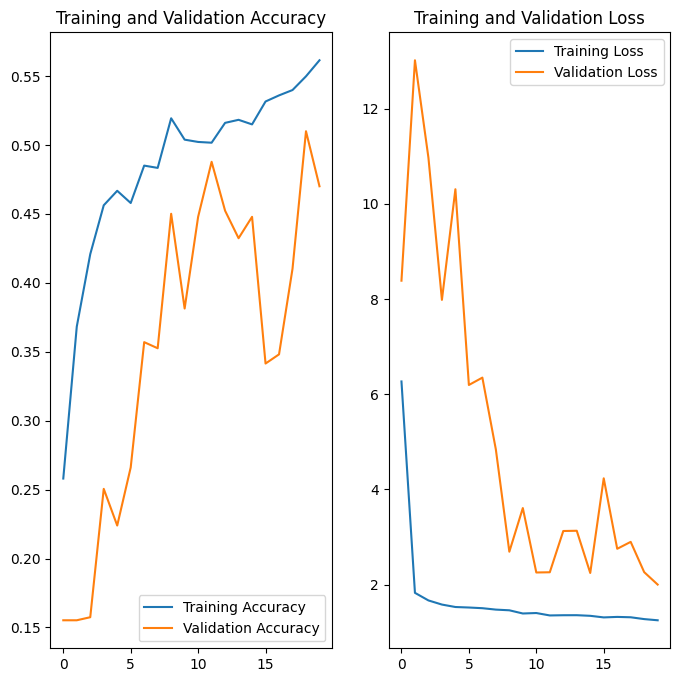

In [29]:
plot_accuracy_loss(history2)

In [30]:
print_accuracy_table(history2)

  train_acc    test_acc
-----------  ----------
   0.258029    0.155211
   0.368217    0.155211
   0.420819    0.157428
   0.456257    0.250554
   0.466777    0.223947
   0.457918    0.266075
   0.48505     0.356984
   0.483389    0.35255
   0.51938     0.450111
   0.503876    0.381375
   0.502215    0.447894
   0.501661    0.487805
   0.516058    0.452328
   0.518272    0.432373
   0.51495     0.447894
   0.531561    0.341463
   0.535991    0.348115
   0.539867    0.4102
   0.549834    0.509978
   0.561462    0.470067


#### Here we can see that the training and validation accuracy is more similar now, which means the augmentation helped with overcoming the overfitting issue.

#### Also we can observer that there are class imbalance among the data. So for enhancing the model further more samples are will be added across all classes

In [32]:
!pip install Augmentor

### Setting the path and removing the output folder if already exists. 
#### This will ensure that previous samples that are already created will be deleted so that it doesn't get overloaded on every run

In [35]:
import Augmentor
path_to_training_dataset= "/content/gdrive/My Drive/data/Train/"
data_dir_train_augmented = pathlib.Path(path_to_training_dataset)
aug_output_path = path_to_training_dataset+"output"
if os.path.exists(aug_output_path):
    os.removedirs(aug_output_path)
    print(f"Output folder {aug_output_path} has been deleted.")

### Generating 500 samples for each class

In [36]:
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 130 image(s) found.
Output directory set to /content/gdrive/My Drive/data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D10289D2440>: 100%|██████████| 500/500 [00:22<00:00, 21.90 Samples/s]


Initialised with 378 image(s) found.
Output directory set to /content/gdrive/My Drive/data/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D0FC421FFA0>: 100%|██████████| 500/500 [00:20<00:00, 24.61 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D10205080D0>: 100%|██████████| 500/500 [00:22<00:00, 22.16 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D0FC4264490>: 100%|██████████| 500/500 [01:47<00:00,  4.64 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/data/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129 at 0x7D0FC41237F0>: 100%|██████████| 500/500 [01:28<00:00,  5.63 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D10205672B0>: 100%|██████████| 500/500 [00:21<00:00, 23.08 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D1036FCB670>: 100%|██████████| 500/500 [00:44<00:00, 11.25 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D10440A5B70>: 100%|██████████| 500/500 [00:20<00:00, 23.93 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D0FC4547B20>: 100%|██████████| 500/500 [00:20<00:00, 24.39 Samples/s]


### Checking training dataset size 

In [37]:
image_count_train = len(list(data_dir_train_augmented.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [38]:
path_list_new = [x for x in glob(os.path.join(data_dir_train_augmented, '*','output', '*.jpg'))]

In [39]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [40]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [41]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [42]:
df2['Label'].value_counts()

,count
Label,
basal cell carcinoma,500
squamous cell carcinoma,500
dermatofibroma,500
seborrheic keratosis,500
actinic keratosis,500
pigmented benign keratosis,500
nevus,500
melanoma,500
vascular lesion,500


## Creating model with augmented data

#### Creating Training and Validation dataset with 80-20 ratio

In [44]:
train_ds_new,val_ds_new = split_train_validation_data(data_dir_train_augmented,img_height,img_width,123,batch_size,0.2)

Found 6757 files belonging to 9 classes.
Using 5406 files for training.
Found 6757 files belonging to 9 classes.
Using 1351 files for validation.


### Creating the model
##### Data augmentation techniques used earlier is also getting used in the model

In [45]:
model3 = Sequential([ layers.Rescaling(1./255, input_shape=(img_height, img_width,3)), data_aug])
model3 = add_layers_to_model(model3,len(class_names))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compiling the model

In [47]:
model3.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

### Training the model with 30 epochs

In [48]:
epochs = 30
## Your code goes here, use 50 epochs.
history3 = model3.fit(
  train_ds_new,
  validation_data=val_ds_new,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 56s 317ms/step - accuracy: 0.2054 - loss: 9.2896 - val_accuracy: 0.0999 - val_loss: 4.7935
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 297ms/step - accuracy: 0.3354 - loss: 1.8090 - val_accuracy: 0.2087 - val_loss: 3.5280
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 83s 307ms/step - accuracy: 0.3649 - loss: 1.7302 - val_accuracy: 0.3479 - val_loss: 2.1204
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 303ms/step - accuracy: 0.3949 - loss: 1.6247 - val_accuracy: 0.3797 - val_loss: 2.1144
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 48s 282ms/step - accuracy: 0.4159 - loss: 1.5504 - val_accuracy: 0.3738 - val_loss: 2.1068
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 83s 292ms/step - accuracy: 0.4493 - loss: 1.5179 - val_accuracy: 0.3035 - val_loss: 2.4662
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 49s 288ms/step - accuracy: 0.4363 - loss: 1.4815 - val_accuracy: 0.4493 - val_loss: 1.5109
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 48s 286ms/step - accuracy: 0.4669 - loss: 1

### Visualizing results

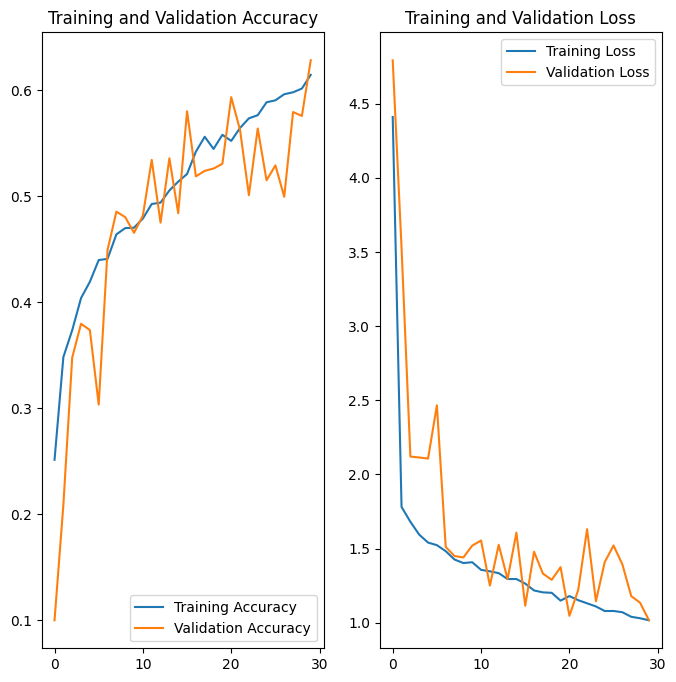

In [49]:
plot_accuracy_loss(history3)

In [50]:
print_accuracy_table(history3)

  train_acc    test_acc
-----------  ----------
   0.251387    0.099926
   0.348317    0.208734
   0.373659    0.34789
   0.403996    0.379719
   0.419349    0.373797
   0.439882    0.303479
   0.440991    0.449297
   0.464114    0.485566
   0.470033    0.480385
   0.470403    0.465581
   0.479097    0.481865
   0.492786    0.534419
   0.494081    0.475204
   0.505549    0.535899
   0.513873    0.484086
   0.521088    0.580311
   0.542175    0.518875
   0.556234    0.524056
   0.544765    0.526277
   0.558084    0.530718
   0.552349    0.593634
   0.564558    0.562546
   0.573622    0.50111
   0.576582    0.564027
   0.58879     0.515174
   0.59064     0.529238
   0.596374    0.49963
   0.598224    0.579571
   0.601739    0.57587
   0.614687    0.628423


#### Here we can see that after removal of class imbalance the accuracy increases a bit and the training and validation accuracy is almost same

#### Now, creating a model without the augmentation techniques 

In [60]:
model4 = Sequential([ layers.Rescaling(1./255, input_shape=(img_height, img_width,3))])
model4 = add_layers_to_model(model4,len(class_names))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compiling the model

In [62]:
model4.compile(loss=tf.keras.losses.CategoricalCrossentropy,
              optimizer='sgd',
              metrics=['accuracy'])

### Training the model

In [63]:
epochs = 30
history4 = model4.fit(
  train_ds_new,
  validation_data=val_ds_new,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 75s 404ms/step - accuracy: 0.2518 - loss: 6.3742 - val_accuracy: 0.1621 - val_loss: 5.5427
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 263ms/step - accuracy: 0.4389 - loss: 1.5314 - val_accuracy: 0.2709 - val_loss: 2.9933
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 46s 275ms/step - accuracy: 0.5403 - loss: 1.2656 - val_accuracy: 0.5019 - val_loss: 1.6619
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 263ms/step - accuracy: 0.6093 - loss: 1.1076 - val_accuracy: 0.5640 - val_loss: 1.4350
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 86s 288ms/step - accuracy: 0.6583 - loss: 0.9439 - val_accuracy: 0.5899 - val_loss: 1.4623
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 276ms/step - accuracy: 0.6954 - loss: 0.8374 - val_accuracy: 0.6839 - val_loss: 0.9650
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 257ms/step - accuracy: 0.7300 - loss: 0.7271 - val_accuracy: 0.7513 - val_loss: 0.8040
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 83s 266ms/step - accuracy: 0.7564 - loss: 0

### Visualizing the results

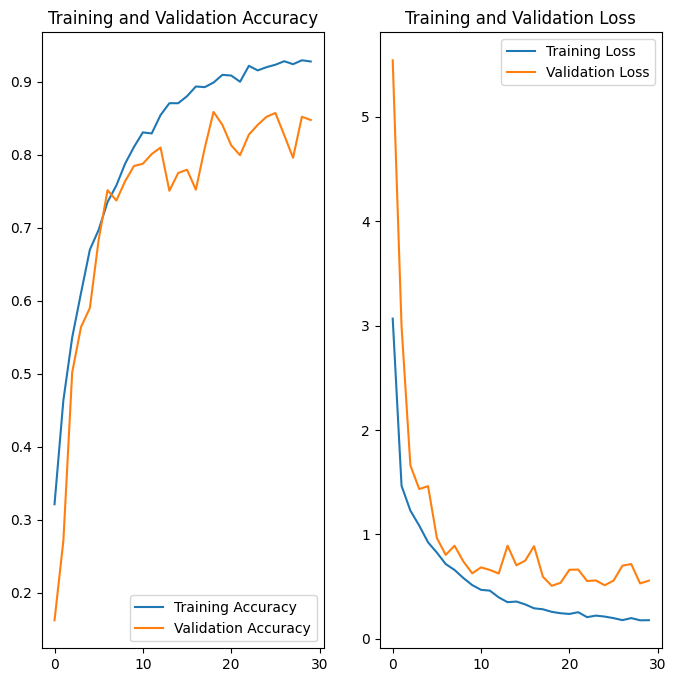

In [64]:
plot_accuracy_loss(history4)

In [ ]:
print_accuracy_table(history4)

#### Here we can see that the accuracy significantly improved with this model

## Now, let's try the model with test data

### Creating test dataset

In [67]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir_test,
        seed=123,
        label_mode = 'categorical',
        image_size=(img_height,img_width),
        batch_size = batch_size
    )

Found 118 files belonging to 9 classes.


### Evaluating the model

In [77]:
result = model4.evaluate(test_data)

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5081 - loss: 4.5620


#### We can see that the model accuracy with test data is around 50%

### Predicting the classes on the test data

In [74]:
predictions = model4.predict(test_data)

3/4 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


In [75]:
predicted_labels = np.argmax(predictions, axis=1)

In [76]:
predicted_labels

array([4, 4, 5, 4, 0, 5, 0, 3, 2, 1, 4, 4, 4, 5, 4, 4, 0, 0, 4, 1, 3, 5,
       4, 0, 4, 8, 4, 5, 4, 5, 7, 5, 5, 4, 8, 1, 5, 4, 4, 4, 4, 4, 4, 2,
       1, 5, 3, 4, 3, 4, 4, 3, 8, 5, 5, 2, 5, 5, 5, 5, 4, 4, 4, 0, 0, 4,
       2, 7, 0, 0, 4, 4, 0, 0, 4, 8, 4, 0, 4, 0, 4, 5, 7, 1, 1, 1, 5, 1,
       4, 1, 2, 5, 3, 7, 4, 4, 8, 1, 5, 5, 5, 4, 8, 2, 4, 5, 1, 7, 5, 4,
       4, 5, 4, 1, 0, 2, 0, 0])

## Conclusion

#### We can see that the model built is predicting almost half of the data correctly. The model can be improved further with higher number of epochs or with more training data